#P1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

alexnet = torchvision.models.alexnet(pretrained=True)

in_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(in_features, 2)

for param in alexnet.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 70.6MB/s]


In [2]:
class CustomCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CustomCIFAR10, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.class_mapping = {0: 0, 1: 1}  # Map original class indices to new class indices
        self.data = [img for img, label in zip(self.data, self.targets) if label in self.class_mapping]
        self.targets = [self.class_mapping[label] for label in self.targets if label in self.class_mapping]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomCIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



100%|██████████| 170498071/170498071 [00:13<00:00, 12846496.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Epoch [1/10], Loss: 0.1790, Accuracy: 92.72%
Epoch [2/10], Loss: 0.0817, Accuracy: 96.89%
Epoch [3/10], Loss: 0.0609, Accuracy: 97.76%
Epoch [4/10], Loss: 0.0438, Accuracy: 98.42%
Epoch [5/10], Loss: 0.0373, Accuracy: 98.60%
Epoch [6/10], Loss: 0.0302, Accuracy: 98.91%
Epoch [7/10], Loss: 0.0233, Accuracy: 99.20%
Epoch [8/10], Loss: 0.0227, Accuracy: 99.14%
Epoch [9/10], Loss: 0.0132, Accuracy: 99.50%
Epoch [10/10], Loss: 0.0124, Accuracy: 99.59%


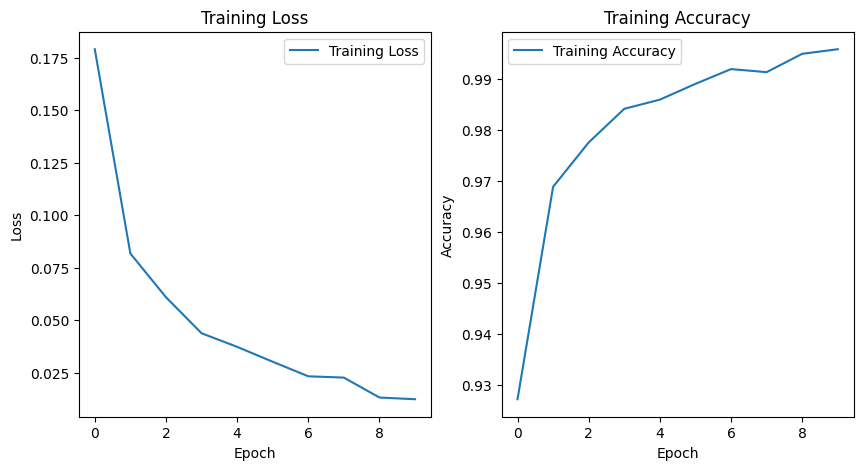

In [3]:
num_epochs = 10
loss_list = []
accuracy_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')

# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [4]:

class CustomCIFAR10Test(datasets.CIFAR10):
    def __init__(self, root, train=False, transform=None, target_transform=None, download=False):
        super(CustomCIFAR10Test, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.class_mapping = {0: 0, 1: 1}
        self.data = [img for img, label in zip(self.data, self.targets) if label in self.class_mapping]
        self.targets = [self.class_mapping[label] for label in self.targets if label in self.class_mapping]


test_dataset = CustomCIFAR10Test(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

alexnet.eval()  # Set the model to evaluation mode

correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        outputs_test = alexnet(inputs_test)
        _, predicted_test = torch.max(outputs_test.data, 1)

        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Files already downloaded and verified
Test Accuracy: 98.50%


#P2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import torch.nn.functional as F

class TripletDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=None)
        self.airplane_indices = np.where(np.array(self.dataset.targets) == 0)[0]
        self.automobile_indices = np.where(np.array(self.dataset.targets) == 1)[0]

    def __getitem__(self, index):
        anchor_label = np.random.choice([0, 1])
        if anchor_label == 0:
            anchor_index = np.random.choice(self.airplane_indices)
        else:
            anchor_index = np.random.choice(self.automobile_indices)

        positive_index = np.random.choice(self.airplane_indices if anchor_label == 0 else self.automobile_indices)
        negative_label = np.random.choice(list({0, 1} - {anchor_label}))
        negative_index = np.random.choice(self.airplane_indices if negative_label == 0 else self.automobile_indices)

        anchor = self.transform(self.dataset[anchor_index][0]) if self.transform else self.dataset[anchor_index][0]
        positive = self.transform(self.dataset[positive_index][0]) if self.transform else self.dataset[positive_index][0]
        negative = self.transform(self.dataset[negative_index][0]) if self.transform else self.dataset[negative_index][0]

        return anchor, positive, negative

    def __len__(self):
        return len(self.dataset)

class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])

    def forward(self, x):
        return self.features(x)

class Classifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_negative = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0)
        return torch.mean(loss)




In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

pretrained_alexnet = torchvision.models.alexnet(pretrained=True)
triplet_dataset = TripletDataset(root='./data', transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
feature_extractor = FeatureExtractor(pretrained_alexnet)
classifier = Classifier(in_features=49152, num_classes=2)
triplet_loss_fn = TripletLoss()
cross_entropy_loss_fn = nn.CrossEntropyLoss()
optimizer_feature_extractor = optim.SGD(feature_extractor.parameters(), lr=0.001, momentum=0.9)
optimizer_classifier = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




triplet_loader = torch.utils.data.DataLoader(triplet_dataset, batch_size=32, shuffle=True)

num_epochs_triplet = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor.to(device)
classifier.to(device)

for epoch in range(num_epochs_triplet):
    feature_extractor.train()
    for batch in triplet_loader:
        anchor, positive, negative = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer_feature_extractor.zero_grad()

        # Forward pass
        embedding_anchor = feature_extractor(anchor)
        embedding_positive = feature_extractor(positive)
        embedding_negative = feature_extractor(negative)

        # Triplet loss
        loss_triplet = triplet_loss_fn(embedding_anchor, embedding_positive, embedding_negative)

        # Backward pass and optimization
        loss_triplet.backward()
        optimizer_feature_extractor.step()

    print(f'Epoch [{epoch + 1}/{num_epochs_triplet}], Triplet Loss: {loss_triplet.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 90.9MB/s]


100%|██████████| 170498071/170498071 [00:04<00:00, 41359938.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/3], Triplet Loss: 0.3631
Epoch [2/3], Triplet Loss: 0.2241
Epoch [3/3], Triplet Loss: 0.1223


In [ ]:
# Freeze the feature extractor and train the classifier with cross-entropy
for param in feature_extractor.parameters():
    param.requires_grad = False

# Create a new dataloader for training the classifier with cross-entropy
class CustomCIFAR10Classifier(datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CustomCIFAR10Classifier, self).__init__(root, train=train, download=download, transform=transform, target_transform=target_transform)
        self.data = [img for img, label in zip(self.data, self.targets) if label in [0, 1]]
        self.targets = [label for label in self.targets if label in [0, 1]]

train_dataset_classifier = CustomCIFAR10Classifier(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
train_loader_classifier = torch.utils.data.DataLoader(train_dataset_classifier, batch_size=32, shuffle=True)

# Training the classifier with cross-entropy
num_epochs_classifier = 10
classifier = Classifier(in_features=9216, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
for epoch in range(num_epochs_classifier):
    classifier.train()
    for inputs, labels in train_loader_classifier:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_classifier.zero_grad()

        # Forward pass
        embeddings = feature_extractor(inputs)
        #print(embeddings.shape)
        outputs_classifier = classifier(embeddings)

        # Cross-entropy loss
        loss_classifier = cross_entropy_loss_fn(outputs_classifier, labels)

        # Backward pass and optimization
        loss_classifier.backward()
        optimizer_classifier.step()

    print(f'Epoch [{epoch + 1}/{num_epochs_classifier}], Classifier Loss: {loss_classifier.item():.4f}')

# Evaluate the model on the test set
classifier.eval()
correct_test = 0
total_test = 0

test_dataset_classifier = CustomCIFAR10Classifier(root='./data', train=False, download=True, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
test_loader_classifier = torch.utils.data.DataLoader(test_dataset_classifier, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs_test, labels_test in test_loader_classifier:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        embeddings_test = feature_extractor(inputs_test)
        outputs_classifier_test = classifier(embeddings_test)
        _, predicted_test = torch.max(outputs_classifier_test.data, 1)

        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Files already downloaded and verified
Epoch [1/10], Classifier Loss: 0.4687
Epoch [2/10], Classifier Loss: 0.4612
Epoch [3/10], Classifier Loss: 0.4895
Epoch [4/10], Classifier Loss: 0.3694
Epoch [5/10], Classifier Loss: 0.3563
Epoch [6/10], Classifier Loss: 0.4947
Epoch [7/10], Classifier Loss: 0.4145
Epoch [8/10], Classifier Loss: 0.3709
Epoch [9/10], Classifier Loss: 0.3499
Epoch [10/10], Classifier Loss: 0.4073
Files already downloaded and verified
Test Accuracy: 87.25%


#P3

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import torch.nn.functional as F

class TripletDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=None)
        self.airplane_indices = np.where(np.array(self.dataset.targets) == 0)[0]
        self.automobile_indices = np.where(np.array(self.dataset.targets) == 1)[0]

    def __getitem__(self, index):
        anchor_label = np.random.choice([0, 1])
        if anchor_label == 0:
            anchor_index = np.random.choice(self.airplane_indices)
        else:
            anchor_index = np.random.choice(self.automobile_indices)

        positive_index = np.random.choice(self.airplane_indices if anchor_label == 0 else self.automobile_indices)
        negative_label = np.random.choice(list({0, 1} - {anchor_label}))
        negative_index = np.random.choice(self.airplane_indices if negative_label == 0 else self.automobile_indices)

        anchor = self.transform(self.dataset[anchor_index][0]) if self.transform else self.dataset[anchor_index][0]
        positive = self.transform(self.dataset[positive_index][0]) if self.transform else self.dataset[positive_index][0]
        negative = self.transform(self.dataset[negative_index][0]) if self.transform else self.dataset[negative_index][0]

        return anchor, positive, negative ,anchor_label

    def __len__(self):
        return len(self.dataset)


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_negative = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0)
        return torch.mean(loss)




Files already downloaded and verified
Epoch [1/3], Classifier Loss: 0.2093, Training Accuracy: 96.66%
Epoch [2/3], Classifier Loss: 0.0451, Training Accuracy: 99.38%
Epoch [3/3], Classifier Loss: 0.0191, Training Accuracy: 99.76%


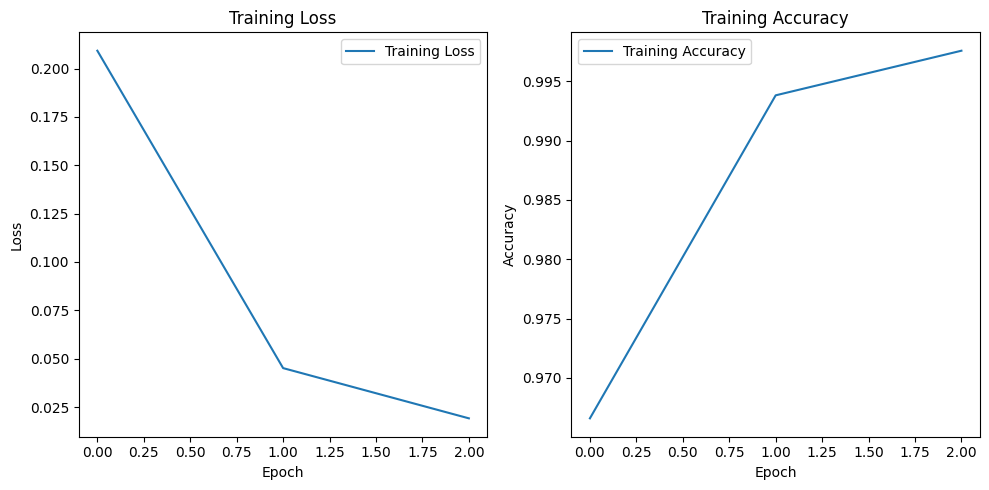

In [7]:
class CustomCIFAR10Classifier(datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CustomCIFAR10Classifier, self).__init__(root, train=train, download=download, transform=transform, target_transform=target_transform)
        self.data = [img for img, label in zip(self.data, self.targets) if label in [0, 1]]
        self.targets = [label for label in self.targets if label in [0, 1]]

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

alexnet = torchvision.models.alexnet(pretrained=True)

in_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(in_features, 2)
triplet_dataset = TripletDataset(root='./data', transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

optimizer = optim.SGD(alexnet.parameters(),lr=0.001, momentum=0.9)
triplet_loss_fn = TripletLoss()
cross_entropy_loss1=nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)



triplet_loader = torch.utils.data.DataLoader(triplet_dataset, batch_size=32, shuffle=True)

num_epochs = 3





epoch_loss_list = []
epoch_accuracy_list = []

# Inside the training loop
for epoch in range(num_epochs):
    alexnet.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in triplet_loader:
        anchor, positive, negative, labels = batch
        anchor, positive, negative, labels = anchor.to(device), positive.to(device), negative.to(device), labels.to(device)

        # Forward pass
        outputs_anchor = alexnet(anchor)
        outputs_positive = alexnet(positive)
        outputs_negative = alexnet(negative)

        # Calculate cross-entropy loss
        cross_entropy_loss = cross_entropy_loss1(outputs_anchor, labels)

        # Calculate triplet loss
        triplet_loss = triplet_loss_fn(outputs_anchor, outputs_positive, outputs_negative)

        # Calculate total loss (sum of cross-entropy and triplet losses)
        total_loss_batch = cross_entropy_loss + triplet_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss_batch.backward()
        optimizer.step()

        # Update total loss for the epoch
        total_loss += total_loss_batch.item()

        # Calculate training accuracy for the epoch
        _, predicted = torch.max(outputs_anchor, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = total_loss / len(triplet_loader)
    accuracy = correct_predictions / total_samples

    # Save loss and accuracy for plotting
    epoch_loss_list.append(average_loss)
    epoch_accuracy_list.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Classifier Loss: {average_loss:.4f}, Training Accuracy: {accuracy * 100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_list, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracy_list, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
#test_dataset = CustomCIFAR10Classifier(root='./data', train=False, download=True, transform=transform)

test_dataset = CustomCIFAR10Classifier(root='./data', train=False, download=True, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
alexnet.eval()  # Set the model to evaluation mode

correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        outputs_test = alexnet(inputs_test)
        _, predicted_test = torch.max(outputs_test.data, 1)

        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Files already downloaded and verified
Test Accuracy: 98.90%
